In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.display import HTML
HTML("<style>.container { width:100% !important; }</style>")

In [3]:
from KuhnPoker import KuhnPokerModel, KuhnPokerInfoSet, ActionNode, PASS, ADD_CHIP, Card, TensorModel, SamplingNode
from ISMCTS import Tree, Constants
from AlphaZero import NNModel, SelfPlayDataV, SelfPlayDataP

import numpy as np
import pickle
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch

In [73]:
start_ix = 0
num_model = 2400

In [74]:
vmodel = []
pmodel = []

for i in range(start_ix, start_ix + num_model):
    vmodel.append(torch.load(f'model/vmodel-{i}.pt'))
    pmodel.append(torch.load(f'model/pmodel-{i}.pt'))

In [75]:
p_info_set = KuhnPokerInfoSet([0], [None, Card.JACK])
q_info_set = KuhnPokerInfoSet([0, 1], [Card.QUEEN, None])
j01_info_set = KuhnPokerInfoSet([0, 1], [None, Card.JACK])
kj01_info_set = KuhnPokerInfoSet([0, 1], [Card.KING, Card.JACK])
qj01_info_set = KuhnPokerInfoSet([0, 1], [Card.QUEEN, Card.JACK])

In [76]:
ps = []
qs = []
vs = []
vs1 = []
vs2 = []
for i in range(num_model):
    p = TensorModel(vmodel[i], pmodel[i]).eval_P(ActionNode(p_info_set))[1]
    q = TensorModel(vmodel[i], pmodel[i]).eval_P(ActionNode(q_info_set))[1]
    v, _ = TensorModel(vmodel[i], pmodel[i]).eval_V(SamplingNode(j01_info_set))
    kj_node = ActionNode(kj01_info_set)
    kj_node.spawned_tree = 1
    v1, _ = TensorModel(vmodel[i], pmodel[i]).eval_V(kj_node)
    qj_node = ActionNode(qj01_info_set)
    qj_node.spawned_tree = 1
    v2, _ = TensorModel(vmodel[i], pmodel[i]).eval_V(qj_node)
    ps.append(p)
    qs.append(q)
    vs.append(v)
    vs1.append(v1)
    vs2.append(v2)
df = pd.DataFrame({'p': ps, 'q': qs, 'v_?J[01]': vs, 'v_KJ[01]': vs1, 'v_QJ[01]': vs2})

In [77]:
df

,p,q,v_?J[01],v_KJ[01],v_QJ[01]
0,0.474381,0.495897,0.010758,-0.088648,-0.070721
1,0.474116,0.495629,0.018171,-0.077389,-0.056450
2,0.473644,0.495079,0.028492,-0.060169,-0.036443
3,0.472969,0.494476,0.089171,0.007532,0.038735
4,0.472325,0.494057,0.177815,0.103128,0.147252
...,...,...,...,...,...
2395,0.268937,0.398307,-0.957307,-2.062021,-0.259981
2396,0.270167,0.368938,-0.991838,-1.935911,-0.017436
2397,0.269326,0.368425,-1.054345,-1.995805,-0.072491
2398,0.270411,0.404306,-1.291088,-1.961729,-0.078446


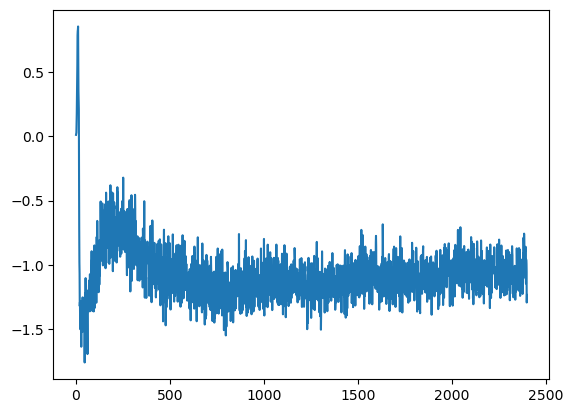

In [78]:
plt.plot(df.index, df['v_?J[01]'])

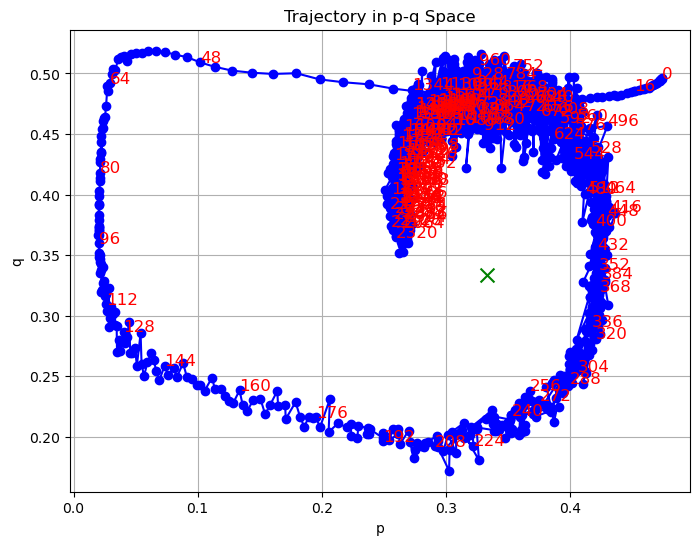

In [79]:
data = df

plt.figure(figsize=(8, 6)) 
plt.plot(data['p'], data['q'], marker='o', linestyle='-', color='b')
plt.title('Trajectory in p-q Space') 
plt.xlabel('p')  
plt.ylabel('q') 
plt.grid(True) 

# Annotate every 10th point with its order number
for i, (p, q) in enumerate(zip(data['p'], data['q'])):
    if i % 16 == 0: 
        plt.text(p, q, str(i), color="red", fontsize=12)
        
plt.scatter([1/3], [1/3], color='green', s=100, marker='x', label='Target (1/3, 1/3)')

plt.show()

In [69]:
with open('self_play/positions.pkl', 'rb') as f:
    games = pickle.load(f)

In [70]:
games

[Position(info_set=[0], cards=?K, policy_target={0: 0.01, 1: 0.99}, action=1, game_id=0, gen_id=0, value_target=1.0),
 Position(info_set=[0], cards=J?, policy_target=None, action=None, game_id=0, gen_id=0, value_target=1.0),
 Position(info_set=[0], cards=JK, policy_target=None, action=None, game_id=0, gen_id=0, value_target=1.0),
 Position(info_set=[01], cards=J?, policy_target={0: 0.98, 1: 0.02}, action=0, game_id=0, gen_id=0, value_target=-1.0),
 Position(info_set=[01], cards=?K, policy_target=None, action=None, game_id=0, gen_id=0, value_target=-1.0),
 Position(info_set=[01], cards=JK, policy_target=None, action=None, game_id=0, gen_id=0, value_target=-1.0),
 Position(info_set=[010], cards=JK, policy_target=None, action=None, game_id=0, gen_id=0, value_target=1.0),
 Position(info_set=[0], cards=?Q, policy_target={0: 0.95, 1: 0.05}, action=0, game_id=1, gen_id=0, value_target=1.0),
 Position(info_set=[0], cards=J?, policy_target=None, action=None, game_id=1, gen_id=0, value_target=1.

In [71]:
data = SelfPlayDataV(games)

In [72]:
subset = []
for g in games:
    if g.info_set.action_history == [0, 1] and g.info_set.cards ==[Card.QUEEN, None]:
        subset.append(g)
df = pd.DataFrame(subset)
df['prob_1'] = df['action_dist'].apply(lambda x: x[1])

KeyError: 'action_dist'

In [ ]:
pd.DataFrame(data)

In [ ]:
df['prob_1'].describe()

In [ ]:
df['outcome'].value_counts()